# **SENET 설명**
SE-Net은 2017년 CVPR 논문 **"Squeeze-and-Excitation Networks"**에서 제안된 네트워크로, 이미지 분류 성능을 높이기 위해 **채널 중요도(Channel-wise Attention)**를 학습하는 모듈을 추가한 구조다.

기존 CNN 모델과의 가장 큰 차이는 명시적인 channel간 상관관계의 학습이다.

squeeze-an-excitation block이 핵심인데,

**1. Squeeze**

입력 피처 맵을 공간적으로 압축해 **채널별 전역 정보(Global Spatial Information)**만 남깁니다. + Global Average Pooling (GAP)을 사용해 각 채널에 대해 평균값을 구합니다.

**2. Excitation**

두 개의 Fully Connected (FC) 레이어와 활성화 함수(ReLU, Sigmoid)를 통해 채널별 가중치를 학습합니다.

FC -> RELU -> FC -> Sigmoid

마지막으로 채널별 가중치를 곱해서 학습을 진행하게 된다.

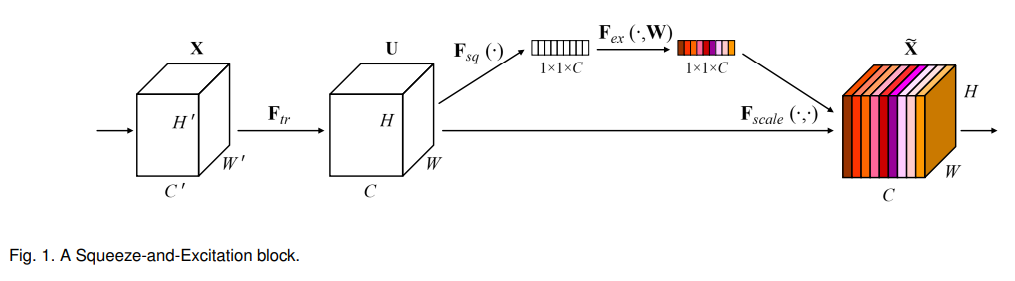

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

# ---------------------------
# SENet 구현
# ---------------------------
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch, channels)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y

class SENet(nn.Module):
    def __init__(self, num_classes=102):
        super(SENet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.se1 = SEBlock(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.se2 = SEBlock(128)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.se1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.se2(x)
        x = F.adaptive_avg_pool2d(x, 1).view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---------------------------
# 실행 예시
# ---------------------------



# ResNet(Residual Network)

ResNet 딥러닝 분야에서 이미지 인식과 컴퓨터 비전 작업에 널리 사용되는 신경망 구조로, 주요 특징은 잔차 학습(Residual Learning) 개념을 도입한 것이다. 가장 큰 특징은 skip connection 이며, 이를 통해 깊은 network에서의 학습이 가능하도록 도와준다.
잔차 블록은 다음과 같은 수식을 따릅니다:

y = F(x) + x 의 구성을 가지며, 이를 통해 신경망은 입력으로 부터의 변화만 학습하면 된다. 아래 그림을 통해 보면 이해가 쉽다. 기존 network와 달리 skip connection이 더해져 혹시라도 신경망의 output이 0이 된다고 할 때, 이를 무시할 수 있게 된다.

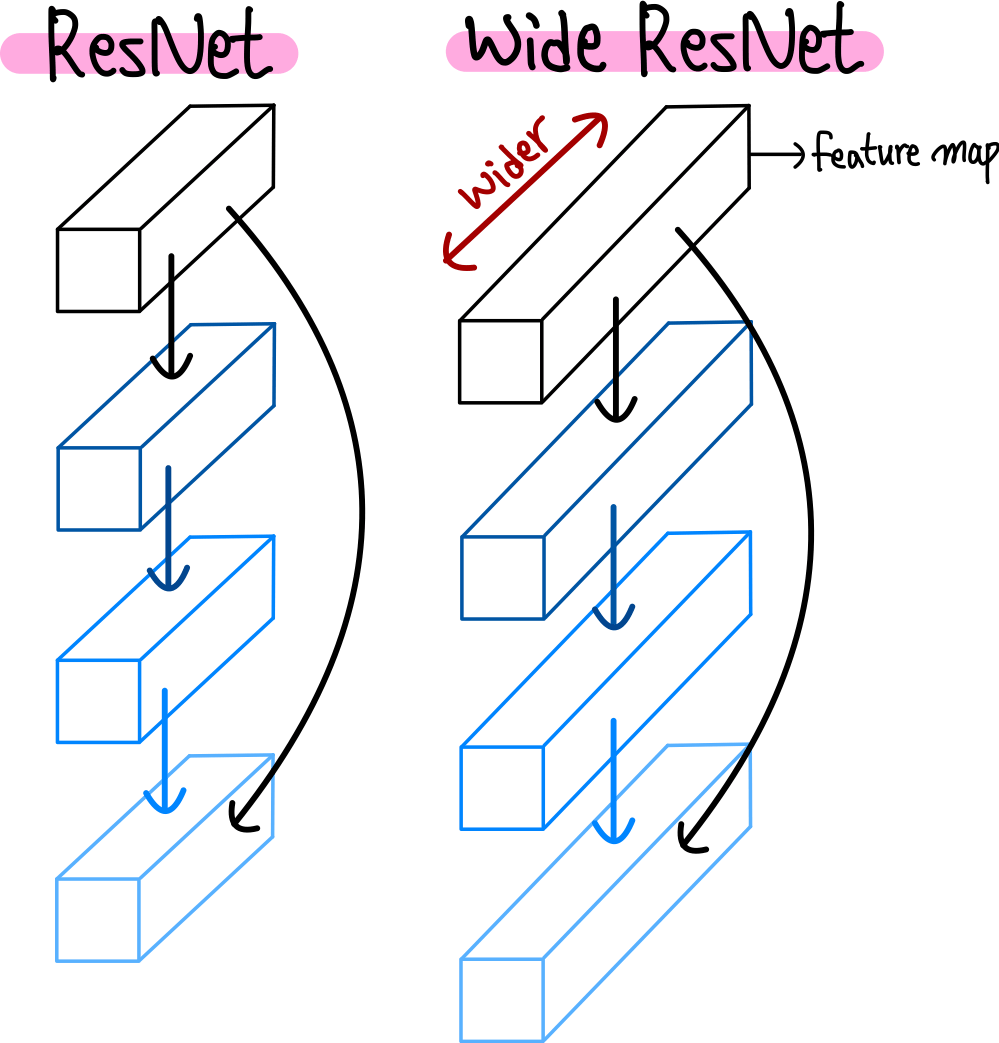

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=102):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [ ]:
# ---------------------------
# 데이터로더 정의
# ---------------------------
def get_dataloaders(batch_size=32):
    transform = transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.Caltech101(
        root='./data_caltech101',
        target_type='category',
        transform=transform,
        download=True
    )
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader

In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    model.to(device)

    for epoch in range(epochs):
        # ---------------------------
        # Train Phase
        # ---------------------------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # ---------------------------
        # Validation Phase
        # ---------------------------
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                v_loss = criterion(val_outputs, val_labels)

                val_running_loss += v_loss.item() * val_inputs.size(0)
                _, val_predicted = val_outputs.max(1)
                val_correct += val_predicted.eq(val_labels).sum().item()
                val_total += val_labels.size(0)

        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = 100.0 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(losses, accuracies, Title):
    epochs_range = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(Title)

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, losses, marker='o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(0, len(losses) + 1, 5))  # 5 에포크 간격으로 눈금 설정

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, accuracies, marker='o', label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.xticks(range(0, len(losses) + 1, 5))  # 5 에포크 간격으로 눈금 설정

    plt.tight_layout()  # 여백 자동 조정
    plt.subplots_adjust(top=0.88)  # 제목과 그래프 간격 조정
    plt.show()


In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_dataloaders()

    # 1) SENet 학습
    senet = SENet(num_classes=102)
    senet_losses, senet_accs, senet_val_losses, senet_val_accs = train_model(senet, train_loader, val_loader, device, epochs=30, lr=1e-3)

    # 2) ResNet 학습
    resnet = ResNet(ResNetBlock, [2,2,2,2], num_classes=102)
    resnet_losses, resnet_accs, resnet_val_losses, resnet_val_accs = train_model(resnet, train_loader, val_loader, device, epochs=30, lr=1e-3)

Files already downloaded and verified
Epoch [1/30] Train Loss: 4.0611, Train Acc: 16.04% | Val Loss: 3.9350, Val Acc: 17.86%
Epoch [2/30] Train Loss: 3.8234, Train Acc: 19.48% | Val Loss: 3.7814, Val Acc: 21.37%
Epoch [3/30] Train Loss: 3.6809, Train Acc: 21.84% | Val Loss: 3.7206, Val Acc: 22.81%
Epoch [4/30] Train Loss: 3.5546, Train Acc: 24.05% | Val Loss: 3.6744, Val Acc: 23.33%
Epoch [5/30] Train Loss: 3.4550, Train Acc: 25.70% | Val Loss: 3.4639, Val Acc: 27.19%
Epoch [6/30] Train Loss: 3.3800, Train Acc: 27.07% | Val Loss: 3.4703, Val Acc: 27.02%
Epoch [7/30] Train Loss: 3.3098, Train Acc: 28.34% | Val Loss: 3.4690, Val Acc: 25.00%
Epoch [8/30] Train Loss: 3.2309, Train Acc: 29.49% | Val Loss: 3.2819, Val Acc: 30.41%
Epoch [9/30] Train Loss: 3.1523, Train Acc: 30.77% | Val Loss: 3.2094, Val Acc: 31.28%
Epoch [10/30] Train Loss: 3.0952, Train Acc: 31.64% | Val Loss: 3.2688, Val Acc: 30.82%
Epoch [11/30] Train Loss: 3.0435, Train Acc: 31.93% | Val Loss: 3.2574, Val Acc: 30.07%
Epo

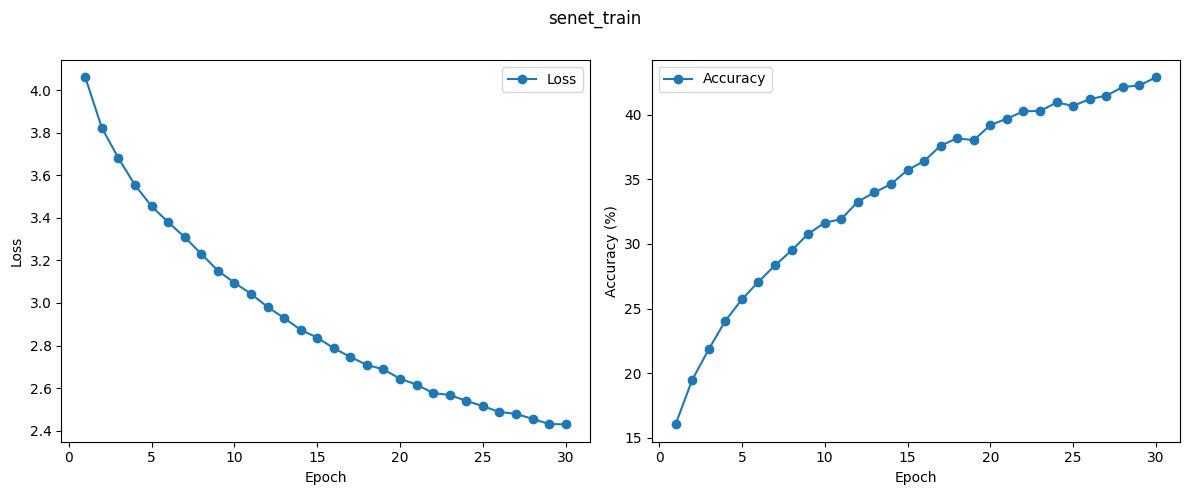

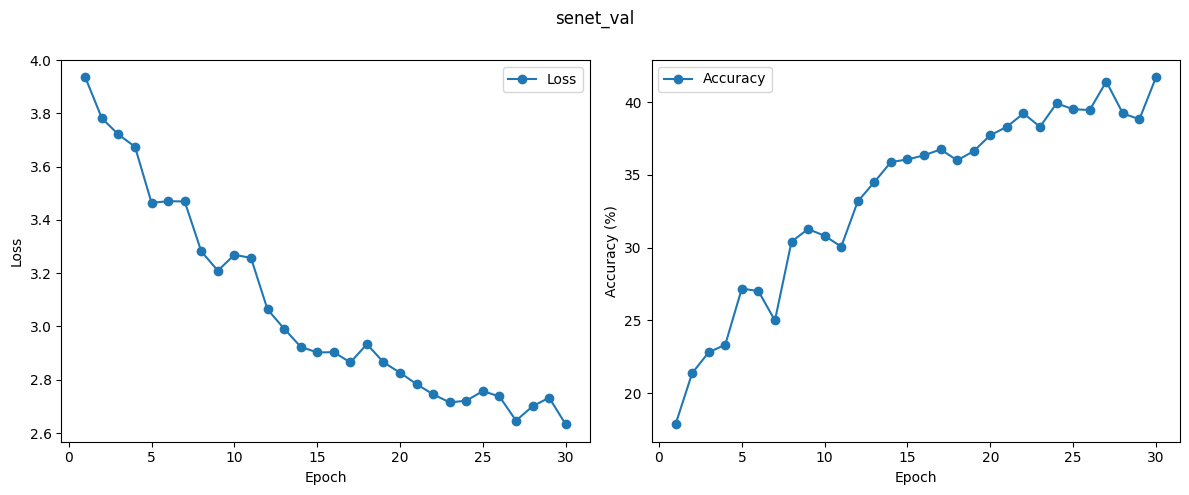

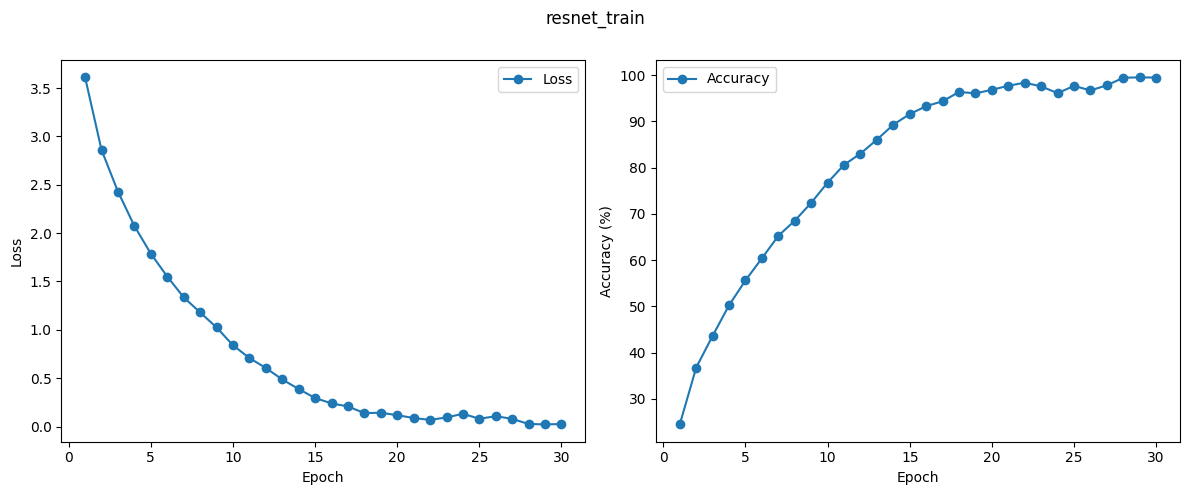

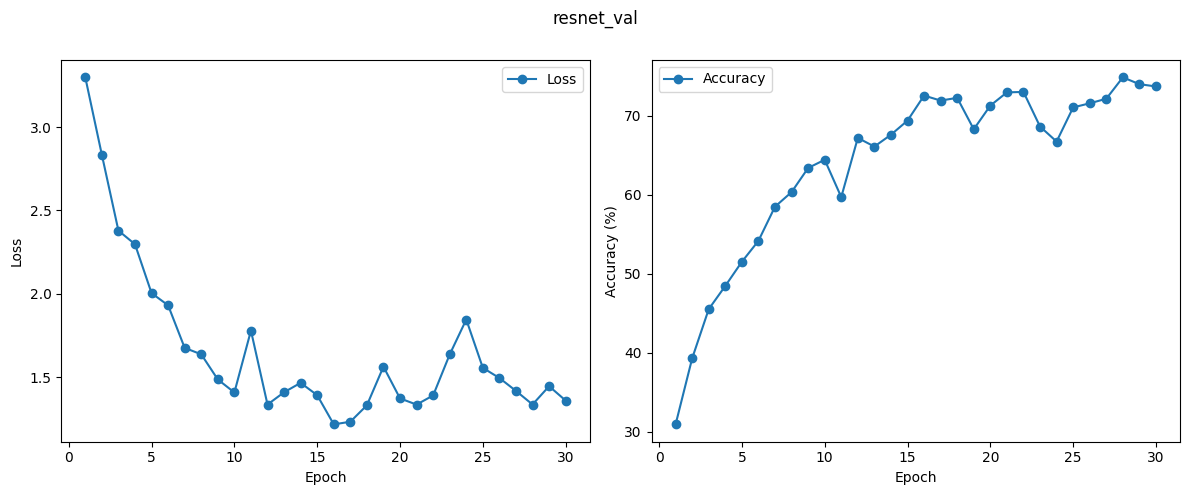

In [ ]:
    plot_metrics(senet_losses, senet_accs, "senet_train")
    plot_metrics(senet_val_losses, senet_val_accs, "senet_val")
    plot_metrics(resnet_losses, resnet_accs, "resnet_train")
    plot_metrics(resnet_val_losses, resnet_val_accs, "resnet_val")

# Caltech101 데이터셋

## 배경
Caltech101은 이미지 분류 및 객체 인식 연구에 널리 사용되는 이미지 데이터셋입니다. 캘리포니아 공과대학(California Institute of Technology)에서 2004년에 공개되었다.

---

## 데이터 구성
- **클래스 수:** 101개의 객체 클래스 + 1개의 배경 클래스  
- **이미지 수:** 약 9,000장  
- **이미지 해상도:** 다양한 해상도 (최대 300x300 픽셀 수준)  
- **다양한 이미지 형태** RGB이미지와 흑백이미지가 모두 존재한다.
---

## 클래스 예시
- 동물: Dalmatian, Elephant, Ketch
- 물체: Airplane, Car, Laptop
- 기하학적 패턴: Faces_easy, Checkerboard 등

---

## 주요 특징
- **클래스 간 불균형:** 각 클래스의 이미지 수가 대략 40~800장으로 다릅니다.
- **다양성:** 객체의 크기, 위치, 배경이 다양해 실제 환경에서의 이미지 분류에 적합합니다.  
- **정제된 데이터:** 노이즈가 적고 이미지 품질이 상대적으로 높은 편입니다.  

---

## 활용 분야
- 이미지 분류(Image Classification)
- 객체 인식(Object Detection)
- 딥러닝 알고리즘 성능 평가

---

# 실험 결과 보고서

## 실험 결과
| 모델     | Train Accuracy | Test Accuracy |
|----------|----------------|---------------|
| **SE-Net** | 40%           | 40%           |
| **ResNet** | 99%           | 74%           |

- Epoch 제한: 컴퓨팅 자원의 한계로 인해 50 epoch 이상 학습이 어려웠다. 본문에서 30 epoch 결과를 사용한 이유는 이전 실험 결과가 손실되었기 때문이다.  

---

## 결과 분석 및 해석

### SE-Net Loss Curve
- SE-Net의 Loss Curve는 안정적으로 감소하는 패턴을 보였으며, 더 오랜 학습이 이루어진다면 현재보다 더 높은 정확도를 달성할 가능성이 있어 보인다.

### ResNet과의 성능 비교
- 하지만 SE-Net이 ResNet보다 더 좋은 성능을 기록하지는 못할 것으로 보인다. 그 렇게 생각한 이유는 다음과 같다.

---

##  성능 저하 원인 분석

### 1. 데이터셋 크기의 제한
- 총 약 **9,000장**의 이미지로 구성된 데이터셋은 크기가 충분하지 않았다.  
- Test set 분리를 위해 **8:2 비율(약 7,200장 학습 데이터)**로 나누었으며, 이는 일반적으로 대규모 모델 학습에는 부족한 데이터 수량이다.

### 2. Grayscale 이미지 변환
- 원본 데이터셋은 **흑백 및 컬러 이미지가 혼합**된 상태다.
- 학습 속도를 고려해 모든 이미지를 **Grayscale 형식**으로 통일해 학습시켰으나, 이는 SE-Net의 강점인 **채널 간 중요도 학습(Squeeze-and-Excitation)**을 충분히 활용하지 못하는 결과로 이어진것 같다.
- SE-Net이 채널 정보를 활용하기 때문에 컬러 이미지로 학습하는 경우 더 나은 성능을 기대할 수 있었을 것이다.

---

## **결론 및 제안**
- SE-Net의 학습을 보다 오래 지속하면 개선된 성능을 보일 가능성이 있으나,       ResNet보다 뛰어난 성능을 기대하기는 어려울 것으로 판단된다.  
- 개선방안:

  1. **데이터 증강**을 통해 학습 데이터 수량 확충  

  2. **컬러 이미지(RGB)** 형식으로 데이터셋 통일  

  3. **컴퓨팅 자원 확충**으로 충분한 Epoch 학습 수행  


# **시사점**

BatchNorm 이 여전히 채널별 중요도를 가지는 역할을 할 수 있음에도, SENET이 잘 학습할 수 있는 이유?

이에 대한 나의 의견은 총 3개다.

1. Batchnorm의 감마 베타를 채널 별 중요도를 암묵적으로 나타낼 수 있다는 것은 맞는 말이지만, 이는 선형적이며, re_scale 하는데 초점이 맞춰져 충분하지 않다고 생각한다.

2. Global average pooling을 통한 전역 정보의 요약

3. Squeeze와 Exitation 을 통한 채널 별 중요도 학습, global average pooling을 통해 압축시킨 정보를 activation func를 추가한 fc layer를 통해 복원하는데, 이 과정이 비선형적이며, 매우 작지만, encoder decoder 의 역할을 하는 것 같다는 생각이 든다. 이를 통해 채널을 복원하는 과정에서 채널간 상호 관계를 학습하려는 시도가 있어 보다 좋은 성능을 냈던 것이 아닐까 추측해본다.